# Preprocessing Neural Response Data

In this example, we demonstrate how to use various preprocessing methods to prepare neural data for analysis using naplib-python.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import naplib as nl
from naplib.preprocessing import filter_butter, normalize, phase_amplitude_extract
from naplib.stats import responsive_ttest

## 1. Preprocessing intracranial EEG (iEEG) responses

The first step is often to extract different frequency band envelopes, such as the highgamma envelope, from the raw data.

In [3]:
# Since we don't have raw iEEG responses to load, we generate random data to simulate the first step.
num_trials = 5
x = [np.random.rand(10000, 6) for _ in range(num_trials)] # 5 trials, each with 10000 samples and 6 channels
fs = [500 for _ in range(num_trials)]

data = nl.Data({'resp': x, 'dataf': fs})


In [6]:
# extract theta and highgamma frequency bands (both their phase and envelope/amplitude)
freq_bands = [[8, 12], [70, 150]]
bandnames = ['theta', 'highgamma']
phase_amp = phase_amplitude_extract(data, Wn=freq_bands, bandnames=bandnames)
phase_amp

Data object of 5 trials containing 4 fields
[{"theta phase": <class 'numpy.ndarray'>, "theta amp": <class 'numpy.ndarray'>, "highgamma phase": <class 'numpy.ndarray'>, "highgamma amp": <class 'numpy.ndarray'>}
{"theta phase": <class 'numpy.ndarray'>, "theta amp": <class 'numpy.ndarray'>, "highgamma phase": <class 'numpy.ndarray'>, "highgamma amp": <class 'numpy.ndarray'>}

...
{"theta phase": <class 'numpy.ndarray'>, "theta amp": <class 'numpy.ndarray'>, "highgamma phase": <class 'numpy.ndarray'>, "highgamma amp": <class 'numpy.ndarray'>}]

In [8]:
# the output is a Data object with a phase and amplitude field for each frequency band
phase_amp.fields

['theta phase', 'theta amp', 'highgamma phase', 'highgamma amp']

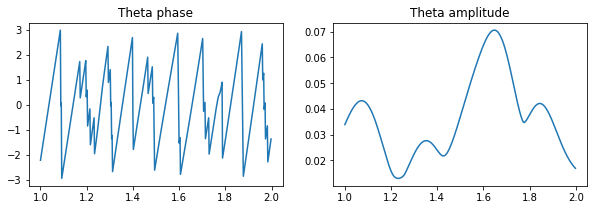

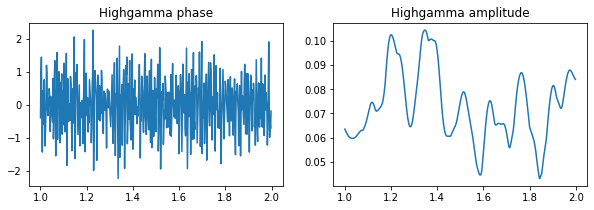

In [14]:
# plot the phase and amplitude for the one second for a single electrode

t = np.arange(0, 10000/500, 1/500)
fig, axes = plt.subplots(1,2,figsize=(10,3))
axes[0].plot(t[500:1000], phase_amp[0]['theta phase'][500:1000,0])
axes[1].plot(t[500:1000], phase_amp[0]['theta amp'][500:1000,0])
axes[0].set_title('Theta phase')
axes[1].set_title('Theta amplitude')
plt.show()

fig, axes = plt.subplots(1,2,figsize=(10,3))
axes[0].plot(t[500:1000], phase_amp[0]['highgamma phase'][500:1000,0])
axes[1].plot(t[500:1000], phase_amp[0]['highgamma amp'][500:1000,0])
axes[0].set_title('Highgamma phase')
axes[1].set_title('Highgamma amplitude')
plt.show()

### Process Highgamma Envelope Responses

Here, we load a dataset that already contains highgamma envelope responses to clean speech


In [2]:
data = nl.io.load_speech_task_data()
data.fields

['name',
 'sound',
 'soundf',
 'dataf',
 'duration',
 'befaft',
 'resp',
 'aud',
 'script']

In [3]:
# there are 10 electrodes of response data
data['resp'][0].shape

(6197, 10)

### Keep only speech-responsive electrodes

Using a t-test between responses to silence and speech (the onset of which is described by the 'befaft' field of the Data), we can determine which electrodes are speech-responsive. Since this simulated data has entirely responsive electrodes, we first set 2 of the electrodes to be random noise.

In [4]:
# this indicates that for this trial, the response includes 1 second of silence before the
# stimulus began, and 1 second at the end after the stimulus ended
data['befaft'][0]

array([1, 1], dtype=uint8)

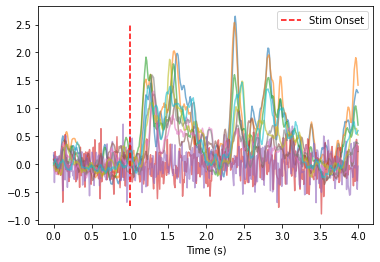

In [5]:
rng = np.random.default_rng(1)
for trial in data:
    trial['resp'][:,3:5] = .25*rng.normal(size=(trial['resp'].shape[0],2))

plt.figure()
plt.plot(np.linspace(0, 4, 400), data['resp'][0][:400], alpha=0.6)
plt.vlines(data['befaft'][0][0], -0.75, 2.5, label='Stim Onset', color='r', linestyle='dashed')
plt.legend()
plt.xlabel('Time (s)')
plt.show()

In [6]:
# Perform t-test to remove electrodes that are not responsive
# This function performs FDR correction by default, but many parameters can be changed to alter
# the test
data_responsive, stats = responsive_ttest(data, random_state=1)
print(stats.keys()) # statistics computed

dict_keys(['pval', 'stat', 'significant', 'alpha'])


In [7]:
# now there are only 8 electrodes remaining
print(data_responsive['resp'][0].shape)

(6197, 8)


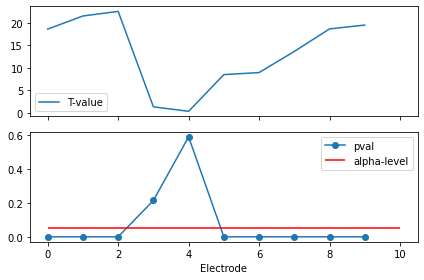

In [8]:
# plot some of the statistics computed

fig, axes = plt.subplots(2,1,sharex=True)
axes[0].plot(np.abs(stats['stat']), label='T-value')
axes[0].legend()

axes[1].plot(np.abs(stats['pval']), 'o-', label='pval')
axes[1].hlines(stats['alpha'], 0, 10, color='r', label='alpha-level')
axes[1].legend()
axes[1].set_xlabel('Electrode')
plt.tight_layout()
plt.show()

## 2. Frequency range filtering (more used for EEG than iEEG)

Let's imagine our data is EEG data instead of iEEG, and we want to extract different frequency bands for further analysis

* delta (0.5-4Hz)
* theta (4-8 Hz)
* alpha (8-13 Hz)
* beta (14-30Hz)

In [9]:
# filter the responses to different bands and set them as new fields of the Data

data_responsive['delta_resp'] = filter_butter(data_responsive, field='resp', Wn=[0.5, 4], order=5)
data_responsive['theta_resp'] = filter_butter(data_responsive, field='resp', Wn=[4, 8], order=5)
data_responsive['alpha_resp'] = filter_butter(data_responsive, field='resp', Wn=[8, 13], order=5)
data_responsive['beta_resp'] = filter_butter(data_responsive, field='resp', Wn=[14, 30], order=5)

#### To make sure the filter bands are correct or meet our requirements, get the filters used and plot them

If we are not satisfied with the filters, we can set the ``order`` parameter in the ``filter_butter`` function to increase the filter order.

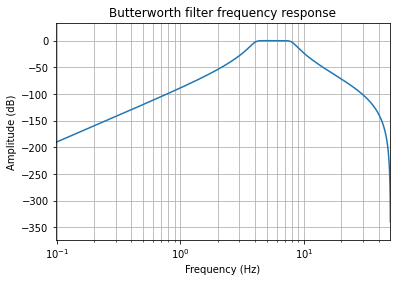

In [10]:
theta_resp, filters = filter_butter(data_responsive, Wn=[4, 8], return_filters=True, order=5)

# plot frequency response
nl.visualization.freq_response(filters[0], fs=data[0]['dataf'])

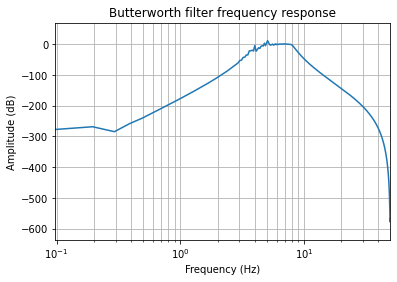

In [11]:
# use a higher order to get steeper cutoff region
theta_resp_2, filters_2 = filter_butter(data_responsive, Wn=[4, 8], order=10, return_filters=True)

# plot frequency response
nl.visualization.freq_response(filters_2[0], fs=data[0]['dataf'])

### Normalize filtered responses

Now that we have bandpassed responses, normalize each one (by z-scoring).

In [12]:
data_responsive['delta_resp'] = normalize(data_responsive, field='delta_resp')
data_responsive['theta_resp'] = normalize(data_responsive, field='theta_resp')
data_responsive['alpha_resp'] = normalize(data_responsive, field='alpha_resp')
data_responsive['beta_resp'] = normalize(data_responsive, field='beta_resp')

### Visualize frequency band responses

Here we just plot the first 10 seconds of a single trial response across all electrodes.

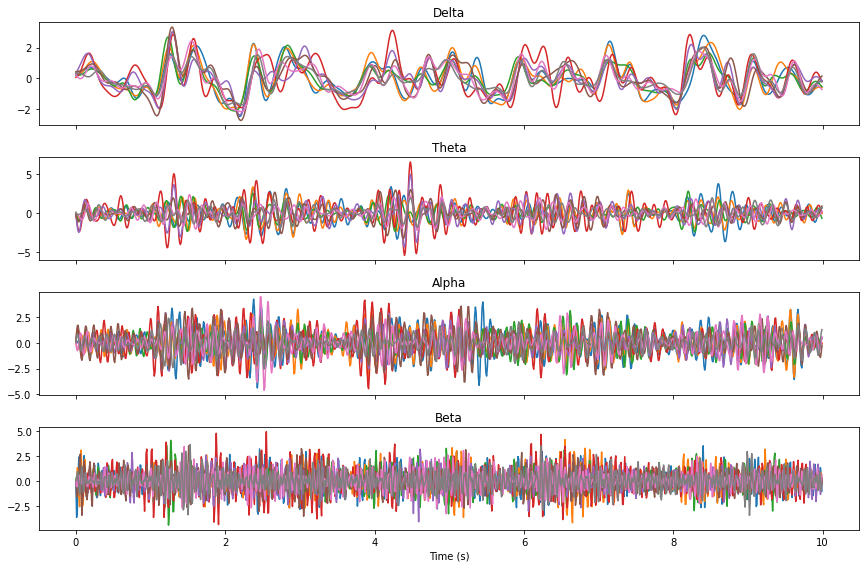

In [15]:
trial = 0
t = np.arange(0, 10*100) / data['dataf'][trial]

fig, axes = plt.subplots(4,1,figsize=(12,8), sharex=True)

axes[0].plot(t, data_responsive['delta_resp'][trial][:10*100])
axes[0].set_title('Delta')
axes[1].plot(t, data_responsive['theta_resp'][trial][:10*100])
axes[1].set_title('Theta')
axes[2].plot(t, data_responsive['alpha_resp'][trial][:10*100])
axes[2].set_title('Alpha')
axes[3].plot(t, data_responsive['beta_resp'][trial][:10*100])
axes[3].set_title('Beta')
axes[3].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()
